In [1]:
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
import os
import warnings
warnings.filterwarnings("ignore")

cluster = SLURMCluster(cores=36, memory='180GB',
                project='science', walltime='08:00:00', queue='compute', interface='ib0')
# workers = cluster.start_workers(1)
# print(cluster.job_script())
client = Client(cluster)

import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as nc
from cmocean import cm
import cartopy
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.interpolate import griddata
from datetime import date
import geopy
import geopy.distance
import seawater as sw
import xarray as xr
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D
import pyroms
import pyroms_toolbox
from pyroms.hgrid import *
from pyroms.vgrid import *
from pyroms.grid import *
from pyroms import io
import pandas as pd 
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from scipy.signal import find_peaks
import scipy.signal as signal
from scipy.stats import linregress
from scipy.signal import medfilt
from astropy.convolution import Box1DKernel,Box2DKernel,convolve
from matplotlib import patches
from matplotlib.collections import PatchCollection
import calendar
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression

outpath = '/vortexfs1/home/yiming.guo/analysis_figures/Passive_Multiyear_2009_2017/Paper_figures_Communications/'

def extract_contour_longest(lon,lat,data,level):
    c=plt.contour(lon,lat,data, levels=[level], colors='k', linewidths=1.5);
    plt.close();
    seg = c.collections[0].get_paths()
    length = np.zeros(len(seg))
    for p in range(len(seg)):
        length[p] = seg[p].vertices.shape[0];
    longest = np.where(length==max(length))[0][0]
    path = c.collections[0].get_paths()[longest].vertices
    return path

locations = ['Wilkinson','SMV','GB','GB2','HC','NJS','NGM','SCS','CHE','JB'] 
locations_long = ['Wilkinson Basin','S. Martha\'s Vineyard','Georges Bank [center]','Georges Bank [edge]','Hudson Canyon','NJ Shelf','Bay of Fundy','Scotian Shelf','S. MAB','Jordan Basin'] 

Wilkinson_lat_center = 42.54; Wilkinson_lon_center = -69.52; ####Wilkinson
SMV_lat_center = 41.13; SMV_lon_center = -70.73; ####SMV
GB_lat_center = 41.61; GB_lon_center = -67.7; ####George bank
GB2_lat_center = 41; GB2_lon_center = -67; ###Geroge's bank (away from center)
HC_lat_center = 39.9; HC_lon_center = -73.10; ####Hudson canyon
NJS_lat_center = 38.57; NJS_lon_center = -74.33; ####New Jersey shelf
NGM_lat_center = 44.2; NGM_lon_center = -66.8; ###north of Gulf of Maine
SCS_lat_center = 44.3; SCS_lon_center = -63.1; ###Scotian Shelf
CHE_lat_center = 36.9; CHE_lon_center = -75.5; ###Chesapeake Bay (south of MAB)
JB_lat_center = 43.5; JB_lon_center = -67.95; ###Jordan basin
cold_core_ring_lat_center = 35; cold_core_ring_lon_center = -71.5; ####dye_01: cold_core_ring
warm_core_ring_lat_center = 40.4; warm_core_ring_lon_center = -63.5; ####dye_01: warm_core_ring

my_grid = pyroms.grid.get_ROMS_grid(gridid='NESS',grid_file='/vortexfs1/share/neon/share/NESS/input_files/NESS1x1_sponge10X.nc',hist_file='/vortexfs1/scratch/yiming.guo/output_try/ness_avg_0001.nc')
z = my_grid.vgrid.z_r[0]; #z<0
mask_5m = np.ones(z.shape); mask_5m[np.where(z<-5)] = np.nan

dataset = nc.Dataset('/proj/neon/yguo/passive_2015/Exp1_Wilkinson/output_passive_Wilkinson_201501/ness_avg_0001.nc','r')
temp = dataset.variables['temp'][0,-1,:,:];
temp[np.where(temp.mask)]= np.nan
land_mask = np.zeros((temp.shape))
land_mask[np.where(np.isnan(temp))] = np.nan
lon_rho = dataset.variables['lon_rho'][:] #time-independent bathymetry
lat_rho = dataset.variables['lat_rho'][:] #time-independent bathymetry
h = dataset.variables['h'][:] #time-independent bathymetry
Ny = lon_rho.shape[0]; Nx = lon_rho.shape[1];
dx = 1e-3*1/dataset.variables['pm'][:]; dy = 1e-3*1/dataset.variables['pn'][:];
dA = dx*dy; ###km^2
pm = dataset.variables['pm'][:];
dataset.close();
open_ocean_mask = np.ones((lon_rho.shape))
open_ocean_mask[np.where(h>400)] = np.nan
path300 = extract_contour_longest(lon_rho,lat_rho,h,300);
path400 = extract_contour_longest(lon_rho,lat_rho,h,400);
path4000 = extract_contour_longest(lon_rho,lat_rho,h,4000);

SMAB_coords = [(-74.8,35.5),(-75.4,35.7),(-75.8,36.97),(-74,39.6),(-73.8,40.4),(-72,39.7),(-73.8,38.0),(-74.6,37)]
SMAB_polygon = Polygon(SMAB_coords)
NMAB_coords = [(-73.8,40.4),(-71.6,41.0),(-71.0,41.4),(-70.38,41.2),(-69.68,41.05),(-69.67,39.95),(-71.4,39.9),(-72,39.7)]
NMAB_polygon = Polygon(NMAB_coords)
WGOM_coords = [(-70.4,42.1),(-70.5,42.9),(-69.9,43.6),(-68.7,44.1),(-67.8,42.05),(-68.3,41.9),(-69,41.3)]
WGOM_polygon = Polygon(WGOM_coords)
EGOM_coords = [(-68.7,44.1),(-66.9,44.6),(-66.5,44.3),(-66,43.2),(-65.5,42.2),(-65.8,41.9),(-66.3,42.1),(-67.8,42.05)]
EGOM_polygon = Polygon(EGOM_coords)
GB_coords = [(-69.68,41.05),(-69,41.3),(-68.3,41.9),(-67.8,42.05),(-66.3,42.1),(-65.8,41.9),(-66.7,40.7),(-68.2,40.2),(-69.67,39.95)]
GB_polygon = Polygon(GB_coords)
SCS_coords = [(-66,43.3),(-65.2,43.4),(-63.7,44.35),(-62.6,44.7),(-61.8,43.0),(-62.7,42.9),(-64.2,42.8),(-65.5,42.2)]
SCS_polygon = Polygon(SCS_coords)
polygons_list = [SMAB_polygon,NMAB_polygon,WGOM_polygon,EGOM_polygon,GB_polygon,SCS_polygon]
all_polygon = unary_union(polygons_list)
domain_coords = [(lon_rho[0,0],lat_rho[0,0]),(lon_rho[-1,0],lat_rho[-1,0]),(lon_rho[-1,-1],lat_rho[-1,-1]),(lon_rho[0,-1],lat_rho[0,-1])]
domain_polygon = Polygon(domain_coords)

sectors = ['SMAB','NMAB','WGOM','EGOM','GB','SCS']

dye_num = np.arange(1,11,1);

months = np.arange(1,13,1);

years = np.arange(2009,2018,1);

colors = plt.cm.tab10(np.linspace(0, 1, len(locations)))

folder = '/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/'


Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


<font size=5> Figure 1. Model Domain, topography, and release locations

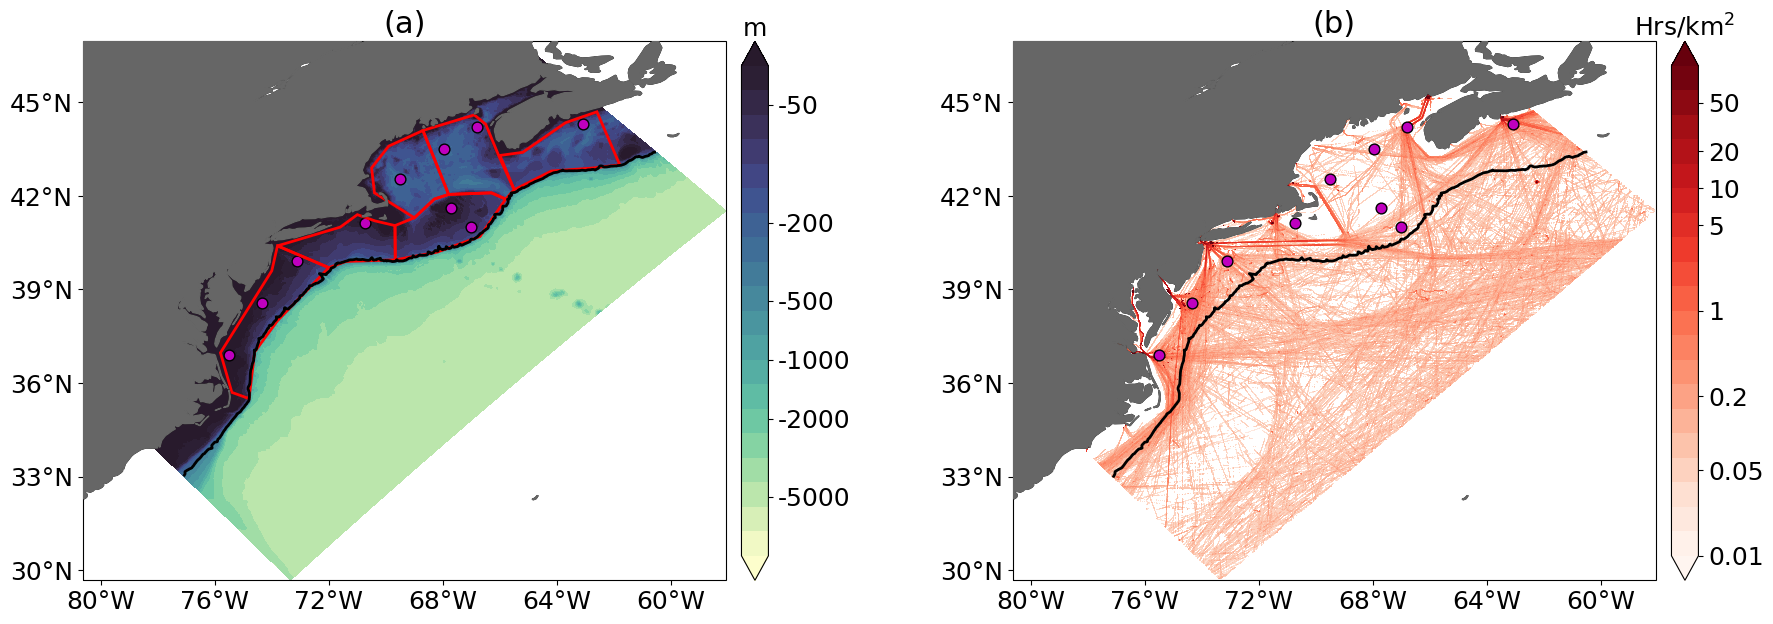

In [47]:
dataset = nc.Dataset('/vortexfs1/scratch/yiming.guo/Observations/Ship_traffic_2015/Ship_combined_2015.nc','r');
ship_lat = dataset.variables['lat'][:]
ship_lon = dataset.variables['lon'][:]
ship_Tankers = dataset.variables['ship_Tankers'][:]
ship_CargoShips = dataset.variables['ship_CargoShips'][:]
ship_Tankers[np.where(np.isnan(ship_Tankers))] = 0
ship_CargoShips[np.where(np.isnan(ship_CargoShips))] = 0
total = ship_Tankers+ship_CargoShips
total[np.where(total==0)] = np.nan
dataset.close()

path200 = extract_contour_longest(lon_rho,lat_rho,h,200);
path250 = extract_contour_longest(lon_rho,lat_rho,h,250);
path4000 = extract_contour_longest(lon_rho,lat_rho,h,4000);
path200[:,0][np.where(path200[:,0]>np.max(ship_lon))] = np.nan
path200[:,1][np.where(path200[:,1]<np.min(ship_lat))] = np.nan
path250[:,0][np.where(path250[:,0]>np.max(ship_lon))] = np.nan
path250[:,1][np.where(path250[:,1]<np.min(ship_lat))] = np.nan
path4000[:,0][np.where(path4000[:,0]>np.max(ship_lon))] = np.nan
path4000[:,1][np.where(path4000[:,1]<np.min(ship_lat))] = np.nan
total1 = np.nansum(total,axis=0)
total1[np.where(total1==0)] = np.nan

point1 = Point(lon_rho[0,0],lat_rho[0,0]); point2 = Point(lon_rho[-1,0],lat_rho[-1,0]);
point3 = Point(lon_rho[-1,-1],lat_rho[-1,-1]); point4 = Point(lon_rho[0,-1],lat_rho[0,-1]); 
polygon = Polygon([point1, point2, point3, point4])
total2 = np.nan*np.zeros((total1.shape));
for j in range(ship_lat.size):
    for i in range(ship_lon.size):
        point = Point(ship_lon[i],ship_lat[j])
        if polygon.contains(point):
            total2[j,i] = total1[j,i]
            
cases = ['Wilkinson','SMV','GB','GB2','HC','NJS','NGM','SCS','CHE','JB']#,'warm_core_ring','cold_core_ring'] 

fig = plt.figure(figsize=(22,7)); fs=20; 

m=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree(central_longitude=-180))
cont = m.contourf(lon_rho,lat_rho,-1*np.log10(h),np.linspace(-4.,-1.5,21),cmap=cm.deep,extend='both',transform = ccrs.PlateCarree());
cbar=plt.colorbar(cont,pad=0.02); cbar.ax.set_title(r'm',fontsize=fs-2,pad=-4); 
cbar.ax.tick_params(labelsize=fs-2); 
ticklabels = [-10,-20,-50,-200,-500,-1000,-2000,-5000]; ticks = -1*np.log10([10,20,50,200,500,1000,2000,5000]);
ticklabels = [-50,-200,-500,-1000,-2000,-5000]; ticks = -1*np.log10([50,200,500,1000,2000,5000]);
cbar.set_ticks(ticks);cbar.set_ticklabels(ticklabels);
contour=m.contour(lon_rho,lat_rho,h, levels=[400], colors='k', linewidths=2,transform = ccrs.PlateCarree());
m.coastlines();m.set_aspect('auto', adjustable=None)
m.add_feature(cartopy.feature.LAND,zorder=100,color=[0.4,0.4,0.4])
m.set_xticks(np.arange(280,301,4),crs=ccrs.PlateCarree()); lon_formatter = cticker.LongitudeFormatter();
m.xaxis.set_major_formatter(lon_formatter); m.xaxis.set_tick_params(labelsize=fs-2);
m.set_yticks(np.arange(30,46,3),crs=ccrs.PlateCarree()); lat_formatter = cticker.LatitudeFormatter();
m.yaxis.set_major_formatter(lat_formatter); m.yaxis.set_tick_params(labelsize=fs-2);
for c in range(len(cases)):
    m.scatter(vars()[cases[c]+'_lon_center'],vars()[cases[c]+'_lat_center'],marker='o',color='m',edgecolor='k',s=60,transform = ccrs.PlateCarree());
plt.title('(a)',fontsize=fs+2);
for k in sectors:
    polygon_outline = patches.Polygon(vars()[k+'_coords'],closed=True, edgecolor='red', linewidth=2, facecolor='none',transform = ccrs.PlateCarree())
    m.add_patch(polygon_outline);

m=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree(central_longitude=-180))
cont = m.contourf(ship_lon,ship_lat,np.log10(total2),np.linspace(-2,2,21),cmap='Reds',extend='both',transform = ccrs.PlateCarree());
cbar=plt.colorbar(cont,pad=0.02); cbar.ax.set_title(r'Hrs/km$^{2}$',fontsize=fs-2,pad=-4); 
cbar.ax.tick_params(labelsize=fs-2); 
ticklabels = [0.01,0.05,0.2,1,5,10,20,50]; ticks = np.log10(ticklabels);
cbar.set_ticks(ticks);cbar.set_ticklabels(ticklabels);
m.plot(path400[:,0],path400[:,1],'k', linewidth=2,transform = ccrs.PlateCarree());
# m.plot(path250[:,0],path250[:,1],'k', linewidth=2,transform = ccrs.PlateCarree());
# m.plot(path4000[:,0],path4000[:,1],'k', linewidth=2,transform = ccrs.PlateCarree());
m.coastlines();m.set_aspect('auto', adjustable=None)
m.add_feature(cartopy.feature.LAND,zorder=100,color=[0.4,0.4,0.4])
m.set_xticks(np.arange(280,301,4),crs=ccrs.PlateCarree()); lon_formatter = cticker.LongitudeFormatter();
m.xaxis.set_major_formatter(lon_formatter); m.xaxis.set_tick_params(labelsize=fs-2);
m.set_yticks(np.arange(30,46,3),crs=ccrs.PlateCarree()); lat_formatter = cticker.LatitudeFormatter();
m.yaxis.set_major_formatter(lat_formatter); m.yaxis.set_tick_params(labelsize=fs-2);
for c in range(len(cases)):
    m.scatter(vars()[cases[c]+'_lon_center'],vars()[cases[c]+'_lat_center'],marker='o',color='m',edgecolor='k',s=60,transform = ccrs.PlateCarree());
m.set_extent([np.min(lon_rho),np.max(lon_rho),np.min(lat_rho),np.max(lat_rho)], crs=ccrs.PlateCarree())
plt.title('(b)',fontsize=fs+2);

# for k in sectors:
#     polygon_outline = patches.Polygon(vars()[k+'_coords'],closed=True, edgecolor='red', linewidth=2, facecolor='none',transform = ccrs.PlateCarree())
#     m.add_patch(polygon_outline);

plt.savefig(outpath+'Fig1_model_domain.png',bbox_inches='tight',dpi = 150)


<font size=5> Figure 2. Snapshots for tracer distributions in January and August 2014 

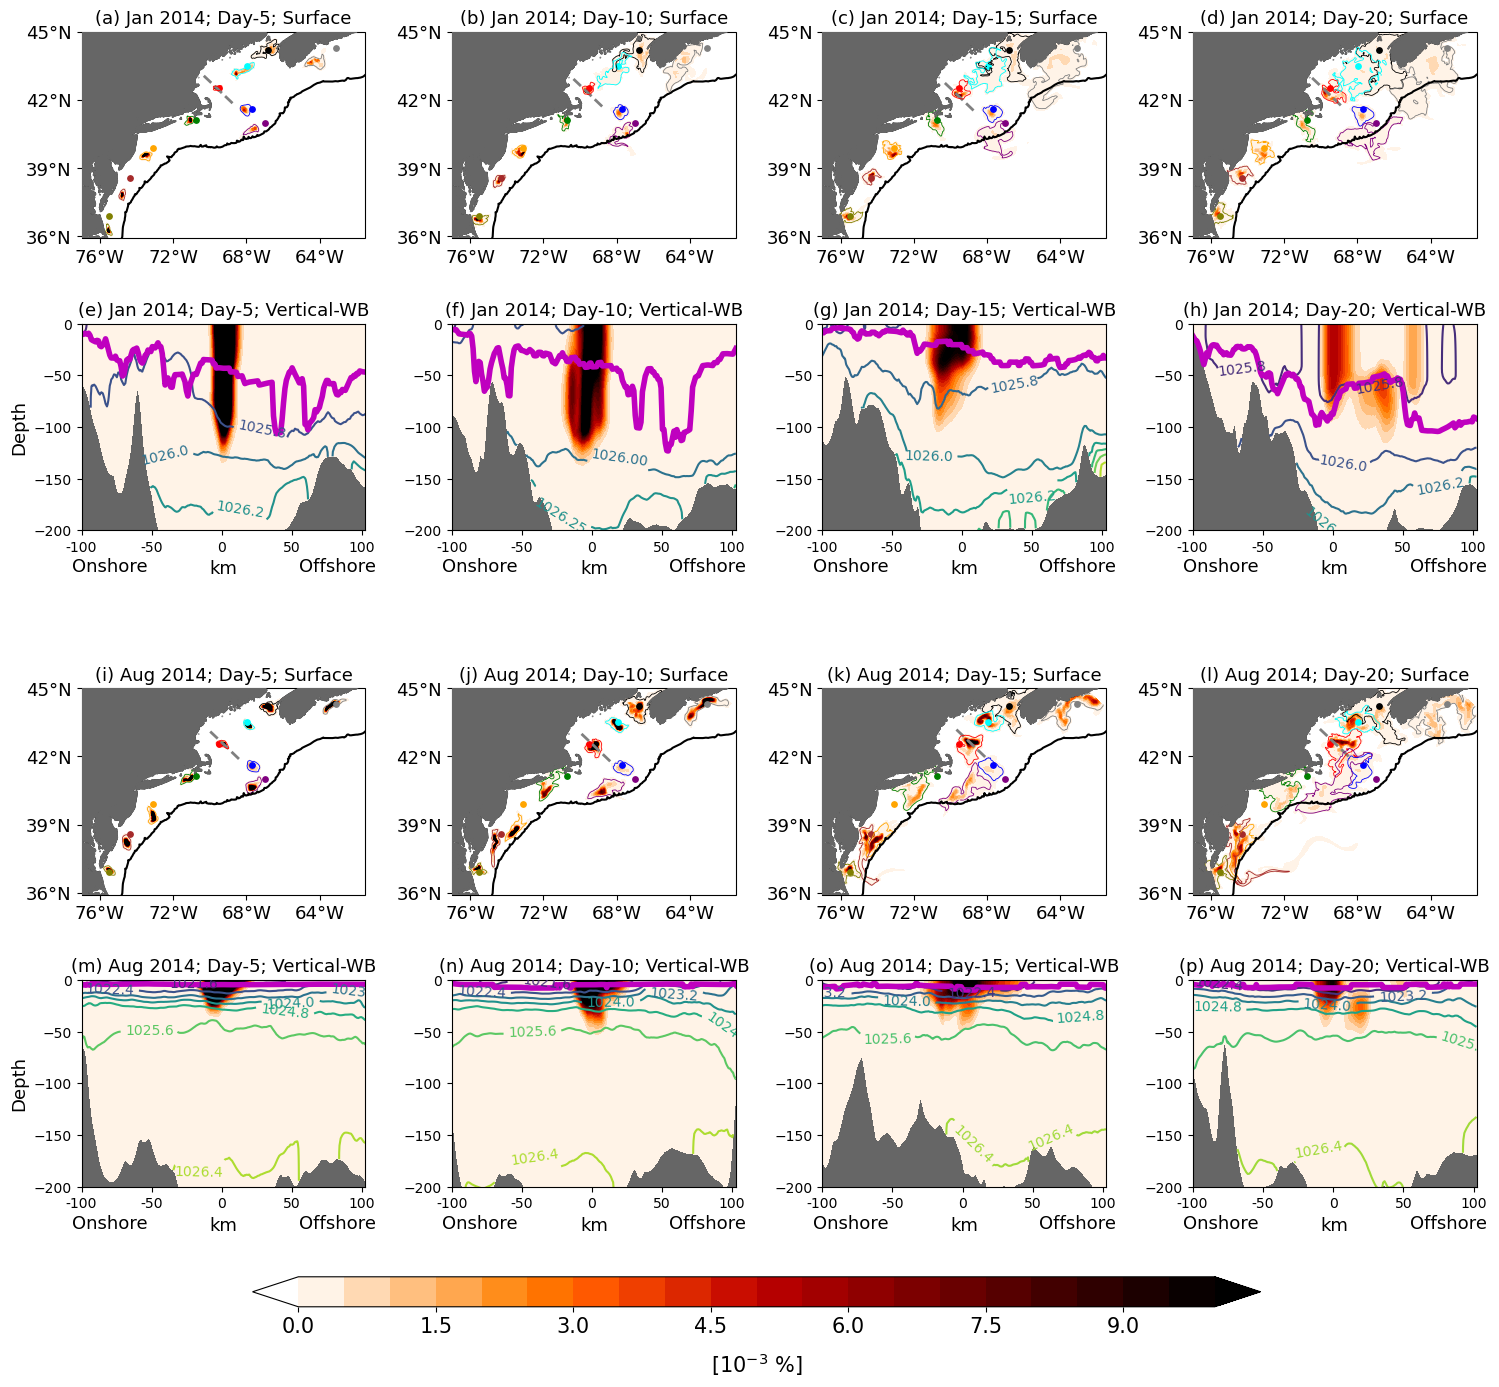

In [8]:
dye_num = np.arange(1,11,1);
yr = 2014; loc = 'Wilkinson'; ndist = 100; cross_dye_num = locations.index(loc)+1
fig = plt.figure(figsize=(18,15)); fs=15; lw=0.6; ms=15;
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'k', 'gray', 'olive', 'cyan']

titles = ['(a) Jan 2014; Day-5','(b) Jan 2014; Day-10','(c) Jan 2014; Day-15','(d) Jan 2014; Day-20',
          '(e) Jan 2014; Day-5','(f) Jan 2014; Day-10','(g) Jan 2014; Day-15','(h) Jan 2014; Day-20',
         '(i) Aug 2014; Day-5','(j) Aug 2014; Day-10','(k) Aug 2014; Day-15','(l) Aug 2014; Day-20', 
          '(m) Aug 2014; Day-5','(n) Aug 2014; Day-10','(o) Aug 2014; Day-15','(p) Aug 2014; Day-20']

gs = fig.add_gridspec(16,19)
subplots = [gs[0:3,0:4],gs[0:3,5:9],gs[0:3,10:14],gs[0:3,15:19],
            gs[4:7,0:4],gs[4:7,5:9],gs[4:7,10:14],gs[4:7,15:19],
            gs[9:12,0:4],gs[9:12,5:9],gs[9:12,10:14],gs[9:12,15:19],
            gs[13:16,0:4],gs[13:16,5:9],gs[13:16,10:14],gs[13:16,15:19]]


custom_cmaps = [mcolors.LinearSegmentedColormap.from_list(f'custom_{color}', ['white', color]) for color in colors]
subplot = 0;
for mon in [1,8]:
    for it in [5,10,15,20]:
         if mon==1:
            subplot = int(it/5)-1;
         elif mon==8:
            subplot = int(it/5)-1+8;
         it = it-1;
         m=fig.add_subplot(subplots[subplot],projection=ccrs.PlateCarree(central_longitude=-180))
         dataset = nc.Dataset('/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/output_'+str(yr)+'/month_'+str(mon).zfill(2)+'/ness_avg_0001.nc','r')
         dye = dataset.variables['dye_'+str(cross_dye_num).zfill(2)][it,-1,:,:]
         jlat = np.where(dye==np.max(dye))[0][0];ilon = np.where(dye==np.max(dye))[1][0];
         plt.plot(lon_rho[jlat-ndist:jlat+ndist,ilon],lat_rho[jlat-ndist:jlat+ndist,ilon],color='grey',linestyle='--',linewidth=2,transform = ccrs.PlateCarree());
         for i in range(len(dye_num)):
             vars()['dye_'+str(dye_num[i]).zfill(2)] = dataset.variables['dye_'+str(dye_num[i]).zfill(2)][it,-1,:,:]  
             vars()['dye_'+str(dye_num[i]).zfill(2)][np.where(vars()['dye_'+str(dye_num[i]).zfill(2)]<=1e-8)] = np.nan;
             total=dataset.variables['dye_01'][it,-1,:,:]+dataset.variables['dye_02'][it,-1,:,:]+dataset.variables['dye_03'][it,-1,:,:]+dataset.variables['dye_04'][it,-1,:,:]+dataset.variables['dye_05'][it,-1,:,:]+dataset.variables['dye_06'][it,-1,:,:]+dataset.variables['dye_07'][it,-1,:,:]+dataset.variables['dye_08'][it,-1,:,:]+dataset.variables['dye_09'][it,-1,:,:]+dataset.variables['dye_10'][it,-1,:,:]
         dataset.close()
         total[np.where(total<=1e-8)] = np.nan;
         cont=m.contourf(lon_rho,lat_rho,1e5*total,np.linspace(0,10,21),cmap='gist_heat_r',extend='both',transform = ccrs.PlateCarree());
         for i in range(len(dye_num)):
              m.contour(lon_rho,lat_rho,1e5*vars()['dye_'+str(dye_num[i]).zfill(2)],levels=[1e-2],colors=colors[i],linewidths=lw,transform = ccrs.PlateCarree());
         m.plot(path400[:,0],path400[:,1],'k',linewidth=1.5,transform = ccrs.PlateCarree());
#          m.plot(path4000[:,0],path4000[:,1],'k',linewidth=1.5,transform = ccrs.PlateCarree());
         m.coastlines();m.set_aspect('auto', adjustable=None)
         m.add_feature(cartopy.feature.LAND,zorder=100,color=[0.4,0.4,0.4])
         m.set_xticks(np.arange(280,301,4),crs=ccrs.PlateCarree()); lon_formatter = cticker.LongitudeFormatter();
         m.xaxis.set_major_formatter(lon_formatter); m.xaxis.set_tick_params(labelsize=fs-2);
         m.set_yticks(np.arange(30,46,3),crs=ccrs.PlateCarree()); lat_formatter = cticker.LatitudeFormatter();
         m.yaxis.set_major_formatter(lat_formatter); m.yaxis.set_tick_params(labelsize=fs-2);
         for c in range(len(locations)):
             m.scatter(vars()[locations[c]+'_lon_center'],vars()[locations[c]+'_lat_center'],marker='o',color=colors[c],s=ms,transform = ccrs.PlateCarree());
         m.set_extent([-77,-61.5,35.9,45],crs=ccrs.PlateCarree());
         m.set_title(titles[subplot]+'; Surface',fontsize=fs-2)

def mld_pdens5(temp,salt,depth):
    pdens = sw.pden(salt,temp,depth,pr=0)
    surface5 = np.mean(pdens[np.where(depth<5)])
    igood = np.where(pdens-surface5-0.03>=0)[0]
    if igood.size==0:
        mld = depth[0];
    else:
        mld = depth[igood[-1]]
    return mld

#along a transect
loc = 'Wilkinson'; yr = 2014; ndist = 100;
dye_num = locations.index(loc)+1
for mon in [1,8]:
    for nday in [5,10,15,20]:
        if mon==1:
            subplot = int(nday/5)-1+4;
        elif mon==8:
            subplot = int(nday/5)-1+12;
        fig.add_subplot(subplots[subplot]);
        folder = '/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/output_'+str(yr)+'/month_'+str(mon).zfill(2)
        dataset = nc.Dataset(folder+'/ness_avg_0001.nc','r')
        dye = dataset.variables['dye_'+str(dye_num).zfill(2)][nday,-1,:,:]
        jlat = np.where(dye==np.max(dye))[0][0];
        ilon = np.where(dye==np.max(dye))[1][0];
        depth = -1*z[:,jlat-ndist:jlat+ndist,ilon]; lat_rho0 = lat_rho[jlat-ndist:jlat+ndist,ilon];
        dx = np.cumsum(1e-3*1/pm[jlat-ndist:jlat+ndist,ilon]);dx = np.repeat(dx[np.newaxis,:],depth.shape[0],axis=0);

        temp0 = dataset.variables['temp'][nday,:,jlat-ndist:jlat+ndist,ilon]
        salt0 = dataset.variables['salt'][nday,:,jlat-ndist:jlat+ndist,ilon]
        dye0 = dataset.variables['dye_'+str(dye_num).zfill(2)][nday,:,jlat-ndist:jlat+ndist,ilon]
        dataset.close();
        pdens0 = sw.pden(salt0,temp0,depth,pr=0)
        cont = plt.contour(-1*dx+np.max(dx),-1*depth,pdens0); plt.clabel(cont);
        mld = np.zeros(temp0.shape[1]);
        for k in range(mld.size):
            mld[k] = mld_pdens5(temp0[:,k],salt0[:,k],depth[:,k])
        plt.plot(-1*dx[0,:]+np.max(dx),-1*mld,'m',linewidth=4)
        cont1 = plt.contourf(-1*dx+np.max(dx),-1*depth,1e5*dye0,np.linspace(0,10,21),cmap='gist_heat_r',extend='both');
        if subplot in [4,12]:
            plt.ylabel('Depth',fontsize=fs-2);
        if subplot in [4,5,6,7,12,13,14,15]:
            plt.xlabel('km',fontsize=fs-2);
            plt.annotate('Onshore', xy=(0.1,-0.2), xycoords='axes fraction', ha='center', fontsize=fs-2)
            plt.annotate('Offshore', xy=(0.9,-0.2), xycoords='axes fraction', ha='center', fontsize=fs-2)
        plt.xticks([0,50,100,150,200],[-100,-50,0,50,100])
        plt.gca().set_facecolor(color=(0.4,0.4,0.4)); plt.title(titles[subplot]+'; Vertical-WB',fontsize=fs-2);
        plt.ylim(-200,0)
cbar_ax = fig.add_axes([0.22, 0.03, 0.56, 0.02]);
cbar = fig.colorbar(cont1, cax=cbar_ax,orientation='horizontal'); 
cbar.ax.tick_params(labelsize=fs);cbar.ax.set_xlabel(r'[10$^{-3}$ %]', fontsize=fs, labelpad=10)

plt.savefig(outpath+'Fig2_Distribution_Snapshots_'+str(yr)+'.png',bbox_inches='tight',dpi = 150)


<font size=5> Figure 3. metric time series for January and August 2014

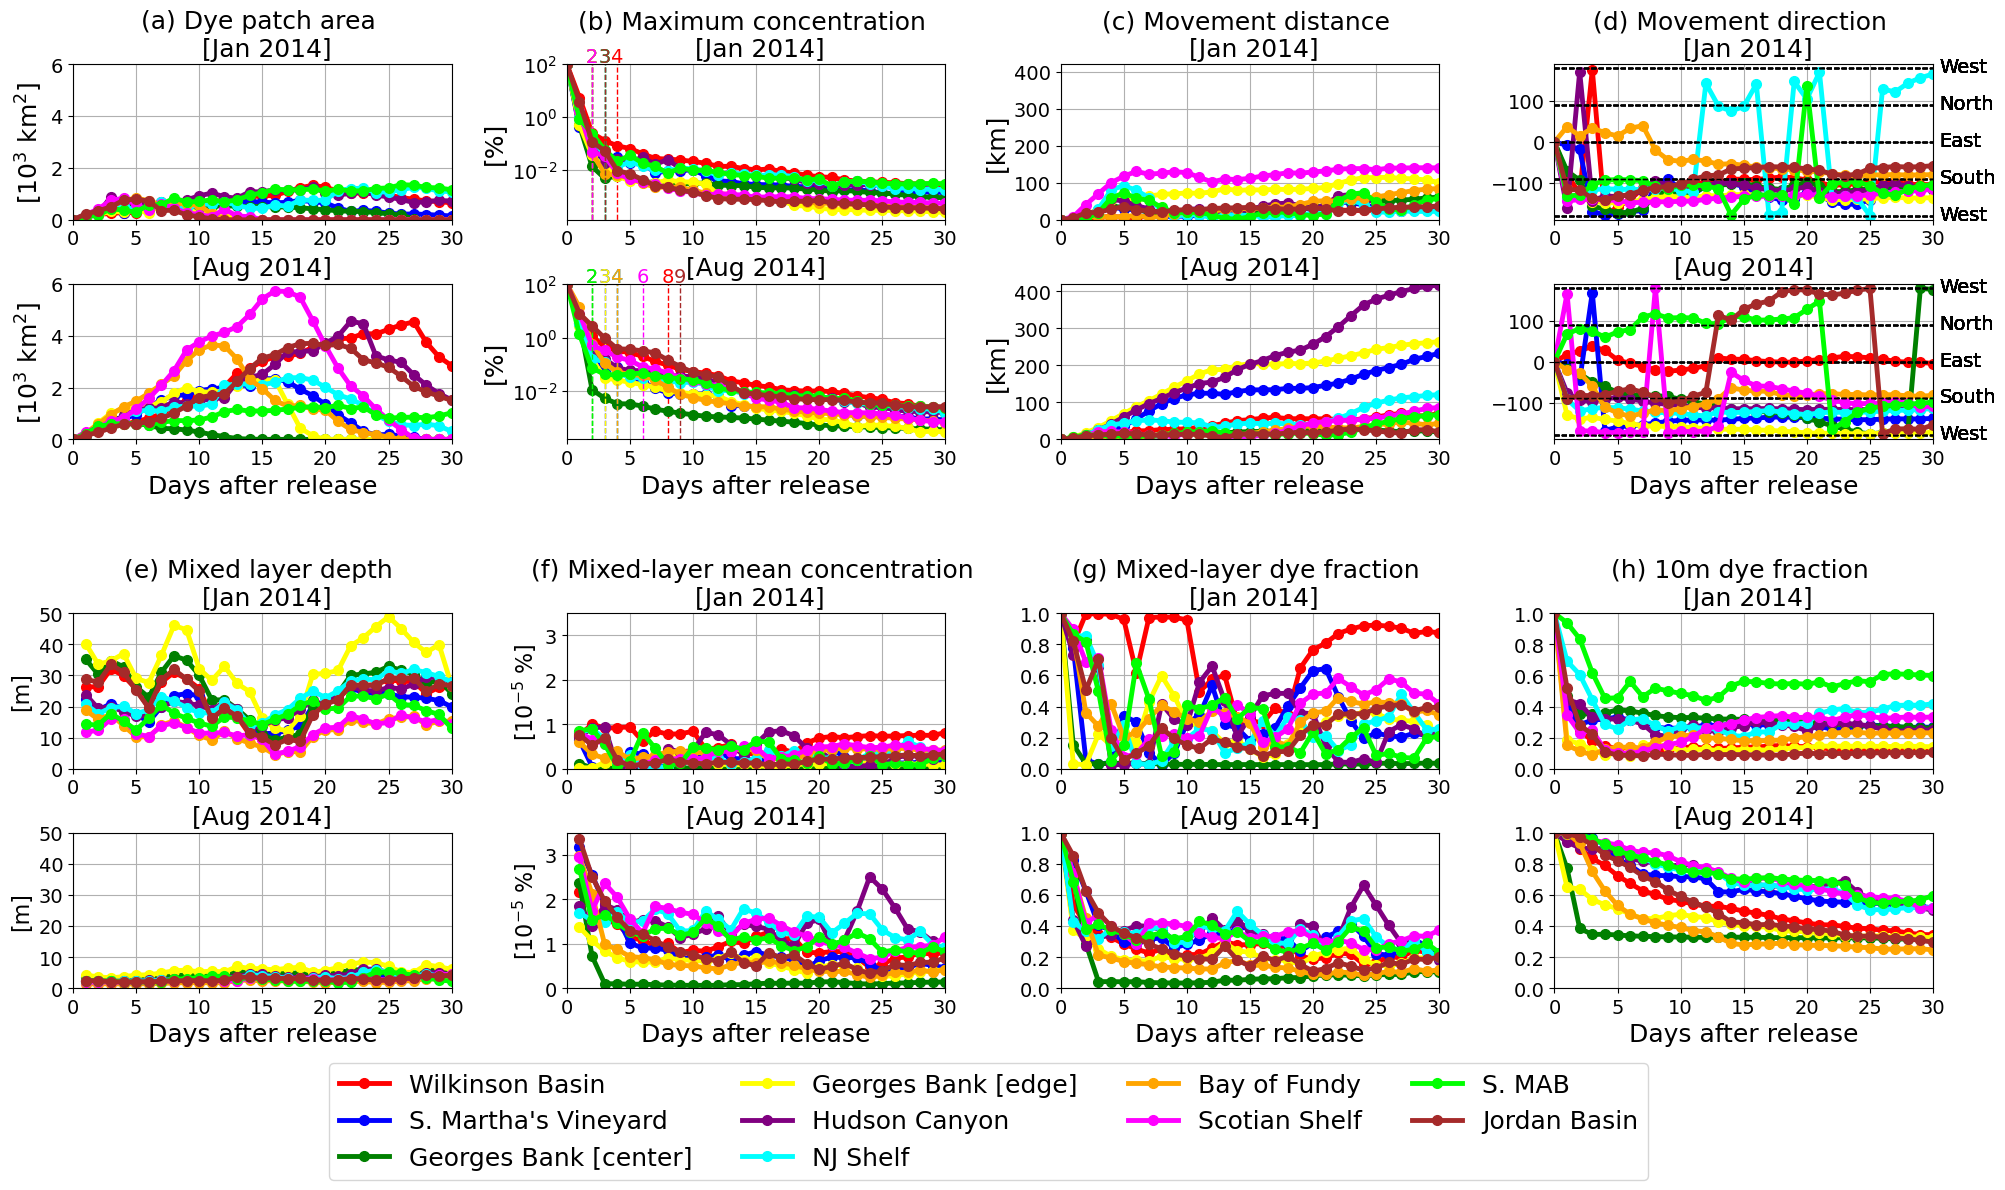

In [44]:
colors = ['Red', 'Blue', 'Green', 'Yellow', 'Purple', 'Cyan', 'Orange', 'Magenta', 'Lime', 'Brown']
metrics = ['Area','Maximum','Dist','Direction']
files = ['Surface_extent.nc','Surface_maximum_decay_time.nc','Lateral_dist_direction_surface_centroid.nc','Lateral_dist_direction_surface_centroid.nc']
names = ['surface_extent_1e_5_1','maximum_concentration','centroid_dist','centroid_direction'];
units = ['[10$^{3}$ km$^{2}$]','[%]','[km]','']
ylim1 = [0,0,0,-190]; ylim2 = [6,100,420,190]
titles = ['(a) Dye patch area \n [Jan 2014]','(b) Maximum concentration \n [Jan 2014]','(c) Movement distance \n [Jan 2014]','(d) Movement direction \n [Jan 2014]',
         '[Aug 2014]','[Aug 2014]','[Aug 2014]','[Aug 2014]'];

folder = '/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/'
years = [2014]; months = [1,8];
for yr in years:
    for mon in months:
        for m in range(len(metrics)):
            metric = metrics[m]; file = files[m]; name = names[m];
            dataset = nc.Dataset(folder+'output_'+str(yr)+'/month_'+str(mon).zfill(2)+'/'+file,'r')
            days = dataset.variables[name][:].shape[1]
            vars()[metric+'_'+str(yr)+'_'+str(mon)] = dataset.variables[name][:,0:days]
            dataset.close();
   
fig = plt.figure(figsize=(24,12)); lw = 3.5; lw2 = 1; ms = 7; k=0; fs = 18;
gs = fig.add_gridspec(17,19)
subplots = [gs[0:3,0:4],gs[0:3,5:9],gs[0:3,10:14],gs[0:3,15:19],
            gs[4:7,0:4],gs[4:7,5:9],gs[4:7,10:14],gs[4:7,15:19],
            gs[10:13,0:4],gs[10:13,5:9],gs[10:13,10:14],gs[10:13,15:19],
            gs[14:17,0:4],gs[14:17,5:9],gs[14:17,10:14],gs[14:17,15:19]]

for yr in years:
    for mon in months: 
        for m in range(len(metrics)):
            metric = metrics[m];
            fig.add_subplot(subplots[k]);
            for i in range(len(locations)):
                if metric in ['Area']:
                    plt.plot(1e-3*np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,0),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]);
                elif metric in ['Dist']:
                    plt.plot(np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,0),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
                elif metric in ['Maximum']:
                    plt.plot(1e2*np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,1),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
                    igood = np.where(np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,np.nan)<=0.001*1)[0][0]
                    plt.plot(np.ones(10)*igood,np.linspace(0,100,10),'--',linewidth=lw2,c=colors[i])
                    plt.text(igood-0.5,120,str(igood), color=colors[i], fontsize=fs-4)
                    plt.yscale('log'); 
                elif metric in ['Direction']:
                    plt.plot(np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,0),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
                    plt.plot(np.arange(0,31,1),180*np.ones(31),'--k',linewidth=lw2)
                    plt.plot(np.arange(0,31,1),90*np.ones(31),'--k',linewidth=lw2)
                    plt.plot(np.arange(0,31,1),0*np.ones(31),'--k',linewidth=lw2)
                    plt.plot(np.arange(0,31,1),-90*np.ones(31),'--k',linewidth=lw2)
                    plt.plot(np.arange(0,31,1),-180*np.ones(31),'--k',linewidth=lw2)
                    plt.text(30.5,170,'West',fontsize=fs-4);plt.text(30.5,80,'North',fontsize=fs-4);plt.text(30.5,-10,'East',fontsize=fs-4);
                    plt.text(30.5,-100,'South',fontsize=fs-4);plt.text(30.5,-190,'West',fontsize=fs-4);
     
            plt.ylabel(units[m],fontsize=fs); 
            if mon == 8:
                plt.xlabel('Days after release',fontsize=fs);
            plt.grid();plt.ylim(ylim1[m],ylim2[m]);plt.xlim(0,30); 
            plt.title(titles[k],fontsize=fs); plt.xticks(fontsize=fs-4); plt.yticks(fontsize=fs-4);
            k=k+1;

metrics = ['mld','mld_meanC','Fraction_mld','Fraction_10']
files = ['mld_pdens5m.nc','Dye_patch_concentration.nc','Dye_fraction_Mixed_Layer.nc','Dye_fraction_surface_10m.nc']
names = ['mld','mean_concentration_mld_pdens','concentration_mld_pdens','concentration_10m'];
units = ['[m]',r'[10$^{-5}$ %]','','']
ylim1 = [0,0,0,0]; ylim2 = [50,3.5,1,1]
titles = ['(e) Mixed layer depth \n [Jan 2014]','(f) Mixed-layer mean concentration \n [Jan 2014]','(g) Mixed-layer dye fraction \n [Jan 2014]','(h) 10m dye fraction \n [Jan 2014]',
         '[Aug 2014]','[Aug 2014]','[Aug 2014]','[Aug 2014]'];
folder = '/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/'
years = [2014]; months = [1,8]; 
for yr in years:
    for mon in months:
        for m in range(len(metrics)):
            metric = metrics[m]; file = files[m]; name = names[m];
            dataset = nc.Dataset(folder+'output_'+str(yr)+'/month_'+str(mon).zfill(2)+'/'+file,'r')
            days = dataset.variables[name][:].shape[1]
            if metric in ['mld']:
                days = dataset.variables[name][:].shape[0]
                vars()[metric+'_'+str(yr)+'_'+str(mon)] = np.zeros((len(locations),days))
                for i in range(len(locations)):
                    dist = (lat_rho-vars()[locations[i]+'_lat_center'])**2+(lon_rho-vars()[locations[i]+'_lon_center'])**2
                    ilat = np.where(dist==np.min(dist))[0][0];ilon = np.where(dist==np.min(dist))[1][0];
                    narea = 200;
                    vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:] = np.nanmean(np.nanmean(dataset.variables[name][:,ilat-narea:ilat+narea,ilon-narea:ilon+narea],axis=2),axis=1)
            elif metric in ['Fraction_mld','Fraction_10']:
                 vars()[metric+'_'+str(yr)+'_'+str(mon)] = dataset.variables[name][:,0:days]/dataset.variables['concentration_total'][:,0:days]
            else:
                vars()[metric+'_'+str(yr)+'_'+str(mon)] = dataset.variables[name][:,0:days]
            dataset.close();
k=0;     
for yr in years:
    for mon in months: 
        for m in range(len(metrics)):
            metric = metrics[m];
            fig.add_subplot(subplots[k+8]);
            for i in range(len(locations)):
                if metric in ['mld']:
                    plt.plot(np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,np.nan),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
                elif metric in ['mld_meanC']:
                    plt.plot(1e7*np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,np.nan),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
                elif metric in ['Fraction_mld']:
                    plt.plot(np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,1),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
                elif metric in ['Fraction_10']:
                    plt.plot(np.insert(vars()[metric+'_'+str(yr)+'_'+str(mon)][i,:],0,1),'-o',c=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
            plt.ylabel(units[m],fontsize=fs-2); 
            if mon == 8:
                plt.xlabel('Days after release',fontsize=fs);
            plt.grid();plt.ylim(ylim1[m],ylim2[m]);plt.xlim(0,30); 
            plt.title(titles[k],fontsize=fs); plt.xticks(fontsize=fs-4); plt.yticks(fontsize=fs-4);
            k=k+1;
            
plt.legend(bbox_to_anchor=(0.28, -0.4),ncol=4, fontsize=fs);

plt.savefig(outpath+'Fig3_Metric_30day_Series_'+str(yr)+'.png',bbox_inches='tight',dpi = 150)


<font size=5> Figure 4. metric climatology

In [4]:
years = np.arange(2009,2018,1); months = np.arange(1,13,1);
metrics = ['Area','Dist','Direction','Maximum','Concentration_mld','Fraction_mld','Fraction_10','mld','decay_time','transfer_vel']
variables = ['surface_extent_1e_5_1','centroid_dist','centroid_direction','maximum_concentration','mean_concentration_mld_pdens',
             'concentration_mld_pdens','concentration_10m','mld','decay_time_0_1percent_1','gas_transfer_vel']
files = ['Surface_extent.nc','Lateral_dist_direction_surface_centroid.nc','Lateral_dist_direction_surface_centroid.nc','Surface_maximum_decay_time.nc',
        'Dye_patch_concentration.nc','Dye_fraction_Mixed_Layer.nc','Dye_fraction_surface_10m.nc','mld_pdens5m.nc','Surface_maximum_decay_time.nc','Gas_transfer_velocity_CO2.nc']

folder = '/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/'

for m in range(len(metrics)):
    metric = metrics[m];
    for yr in years:
        vars()[metric+'_mean_'+str(yr)] = np.zeros((12,len(locations)))
        for mon in np.arange(1,13,1):
            dataset = nc.Dataset(folder+'output_'+str(yr)+'/month_'+str(mon).zfill(2)+'/'+files[m],'r')
            if metric in ['Fraction_10']:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_mean_'+str(yr)][mon-1,:] = np.mean(dataset.variables['concentration_10m'][:,0:days]/dataset.variables['concentration_total'][:,0:days],axis=1)
            elif metric in ['Fraction_mld']:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_mean_'+str(yr)][mon-1,:] = np.mean(dataset.variables['concentration_mld_pdens'][:,0:days]/dataset.variables['concentration_total'][:,0:days],axis=1)
            elif metric in ['mld']:
                narea = 200; days = dataset.variables[variables[m]][:].shape[0]
                for i in range(len(locations)):
                    dist = (lat_rho-vars()[locations[i]+'_lat_center'])**2+(lon_rho-vars()[locations[i]+'_lon_center'])**2
                    ilat = np.where(dist==np.min(dist))[0][0];ilon = np.where(dist==np.min(dist))[1][0];
                    data = np.nanmean(np.nanmean(dataset.variables['mld'][:,ilat-narea:ilat+narea,ilon-narea:ilon+narea],axis=2),axis=1)
                    vars()[metric+'_mean_'+str(yr)][mon-1,i] = np.nanmean(data)
            elif metric in ['decay_time']:
                vars()[metric+'_mean_'+str(yr)][mon-1,:] = dataset.variables['decay_time_0_1percent_1'][:]
            else:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_mean_'+str(yr)][mon-1,:] = np.mean(dataset.variables[variables[m]][:,0:days],axis=1)

            dataset.close();
            
for m in range(len(metrics)):
    metric = metrics[m];     
    vars()[metric+'_mean_mean'] = np.zeros((12,len(locations)))
    vars()[metric+'_mean_std'] = np.zeros((12,len(locations)))
    for num in np.arange(1,len(locations)+1,1):
        for mon in np.arange(1,13,1):
            series = np.zeros(len(years));
            for yr in years:
                series[yr-years[0]] = vars()[metric+'_mean_'+str(yr)][mon-1,num-1]
            vars()[metric+'_mean_mean'][mon-1,num-1] = np.mean(series)
            vars()[metric+'_mean_std'][mon-1,num-1] = np.std(series)
       

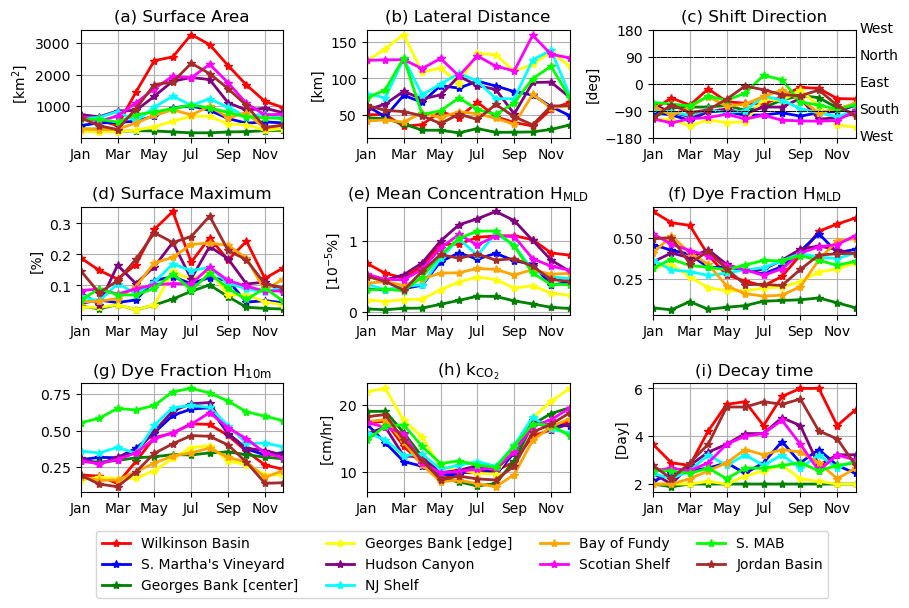

In [49]:
fig = plt.figure(figsize=(10,6)); fs = 10; lw=2; lw2=0.5;
metrics = ['Area','Dist','Direction','Maximum','Concentration_mld','Fraction_mld','Fraction_10','transfer_vel','decay_time']
titles = ['(a) Surface Area','(b) Lateral Distance','(c) Shift Direction','(d) Surface Maximum',r'(e) Mean Concentration H$_{\rm MLD}$',r'(f) Dye Fraction H$_{\rm MLD}$',r'(g) Dye Fraction H$_{\rm 10m}$',r'(h) k$_{\rm CO_{2}}$','(i) Decay time']
units = ['[km$^{2}$]','[km]','[deg]','[%]','[10$^{-5}\%$]','','','[cm/hr]','[Day]']
colors = ['Red', 'Blue', 'Green', 'Yellow', 'Purple', 'Cyan', 'Orange', 'Magenta', 'Lime', 'Brown']
xticklabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
gs = fig.add_gridspec(8,11)
subplots = [gs[0:2,0:3],gs[0:2,4:7],gs[0:2,8:11],
           gs[3:5,0:3],gs[3:5,4:7],gs[3:5,8:11],
           gs[6:8,0:3],gs[6:8,4:7],gs[6:8,8:11]]

for m in range(len(metrics)):
    metric = metrics[m];
    fig.add_subplot(subplots[m])   
    for num in np.arange(1,len(locations)+1,1):
        if metric in ['Maximum']:
            plt.plot(100*vars()[metric+'_mean_mean'][:,num-1],'-*',color=colors[num-1],linewidth=lw,label=locations_long[num-1]);
        elif metric in ['Concentration_mld']:
            plt.plot(1e7*vars()[metric+'_mean_mean'][:,num-1],'-*',color=colors[num-1],linewidth=lw,label=locations_long[num-1]);
        else:
            plt.plot(vars()[metric+'_mean_mean'][:,num-1],'-*',color=colors[num-1],linewidth=lw,label=locations_long[num-1]);
        if metric in ['Direction']:
            plt.plot(np.arange(0,12,1),180*np.ones(12),'--k',linewidth=lw2)
            plt.plot(np.arange(0,12,1),90*np.ones(12),'--k',linewidth=lw2)
            plt.plot(np.arange(0,12,1),0*np.ones(12),'--k',linewidth=lw2)
            plt.plot(np.arange(0,12,1),-90*np.ones(12),'--k',linewidth=lw2)
            plt.plot(np.arange(0,12,1),-180*np.ones(12),'--k',linewidth=lw2)
            if num==1:
                plt.text(11.2,170,'West');plt.text(11.2,80,'North');plt.text(11.2,-10,'East');plt.text(11.2,-100,'South');plt.text(11.2,-190,'West');
            plt.yticks([-180,-90,0,90,180]); plt.ylim(-180,180);
        #plt.errorbar(np.arange(0,12,1),vars()[metric+'_mean_mean'][:,num-1],vars()[metric+'_mean_std'][:,num-1],fmt='o',color = 'k',ecolor='k',capsize=5)
        #plt.plot(np.linspace(-1,12,12),np.mean(vars()[metric+'_mean_mean'][:,num-1])*np.ones(12),color='k',linestyle='--');
    plt.grid();plt.xlim(0,11);plt.ylabel(units[m],fontsize=fs)
    plt.xticks(np.arange(0,12,1)[0::2],xticklabels[0::2],fontsize=fs);plt.yticks(fontsize=fs);
    plt.title(titles[m],fontsize=fs+2);
#plt.legend(bbox_to_anchor=(2.2,3));
plt.legend(bbox_to_anchor=(0.9, -0.3),ncol=4, fontsize=fs);

#plt.savefig(outpath+'Fig4_Metric_Clim.png',bbox_inches='tight',dpi = 150)


<font size=5> Figure 5. SSI index

In [2]:
####how to weigh different metric based on their correlation scales
years = np.arange(2009,2018,1); months = np.arange(1,13,1);
metrics = ['Area','Dist','Direction','Maximum','Concentration_mld','Fraction_mld','Fraction_10','mld','decay_time','transfer_vel']
variables = ['surface_extent_1e_5_1','centroid_dist','centroid_direction','maximum_concentration','mean_concentration_mld_pdens',
             'concentration_mld_pdens','concentration_10m','mld','decay_time_0_1percent_1','gas_transfer_vel']
files = ['Surface_extent.nc','Lateral_dist_direction_surface_centroid.nc','Lateral_dist_direction_surface_centroid.nc','Surface_maximum_decay_time.nc',
        'Dye_patch_concentration.nc','Dye_fraction_Mixed_Layer.nc','Dye_fraction_surface_10m.nc','mld_pdens5m.nc','Surface_maximum_decay_time.nc','Gas_transfer_velocity_CO2.nc']

folder = '/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/'

for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_series'] = np.zeros((len(years)*len(months),len(locations)))
    for yr in years:
        for mon in np.arange(1,13,1):
            dataset = nc.Dataset(folder+'output_'+str(yr)+'/month_'+str(mon).zfill(2)+'/'+files[m],'r')
            if metric in ['Fraction_10']:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_series'][(yr-years[0])*12+mon-1,:] = np.mean(dataset.variables['concentration_10m'][:,0:days]/dataset.variables['concentration_total'][:,0:days],axis=1)
            elif metric in ['Fraction_mld']:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_series'][(yr-years[0])*12+mon-1,:] = np.mean(dataset.variables['concentration_mld_pdens'][:,0:days]/dataset.variables['concentration_total'][:,0:days],axis=1)
            elif metric in ['mld']:
                narea = 200; days = dataset.variables[variables[m]][:].shape[0]
                for i in range(len(locations)):
                    dist = (lat_rho-vars()[locations[i]+'_lat_center'])**2+(lon_rho-vars()[locations[i]+'_lon_center'])**2
                    ilat = np.where(dist==np.min(dist))[0][0];ilon = np.where(dist==np.min(dist))[1][0];
                    data = np.nanmean(np.nanmean(dataset.variables['mld'][:,ilat-narea:ilat+narea,ilon-narea:ilon+narea],axis=2),axis=1)
                    vars()[metric+'_series'][(yr-years[0])*12+mon-1,i] = np.nanmean(data)
            elif metric in ['decay_time']:
                vars()[metric+'_series'][(yr-years[0])*12+mon-1,:] = dataset.variables['decay_time_0_1percent_1'][:]
            else:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_series'][(yr-years[0])*12+mon-1,:] = np.mean(dataset.variables[variables[m]][:,0:days],axis=1)
            dataset.close();
            
R2 = np.zeros((len(metrics),len(locations)));
for l in range(len(locations)):
    for m in range(len(metrics)):
        y_vars = [];
        for m1 in range(len(metrics)):
            if m1 != m:
                y_vars.append(vars()[metrics[m1]+'_series'][:,l])
        X = np.column_stack([y for y in y_vars])
        model = LinearRegression()
        model.fit(X,vars()[metrics[m]+'_series'][:,l])
        R2[m,l] = 1.0-(model.score(X,vars()[metrics[m]+'_series'][:,l]))


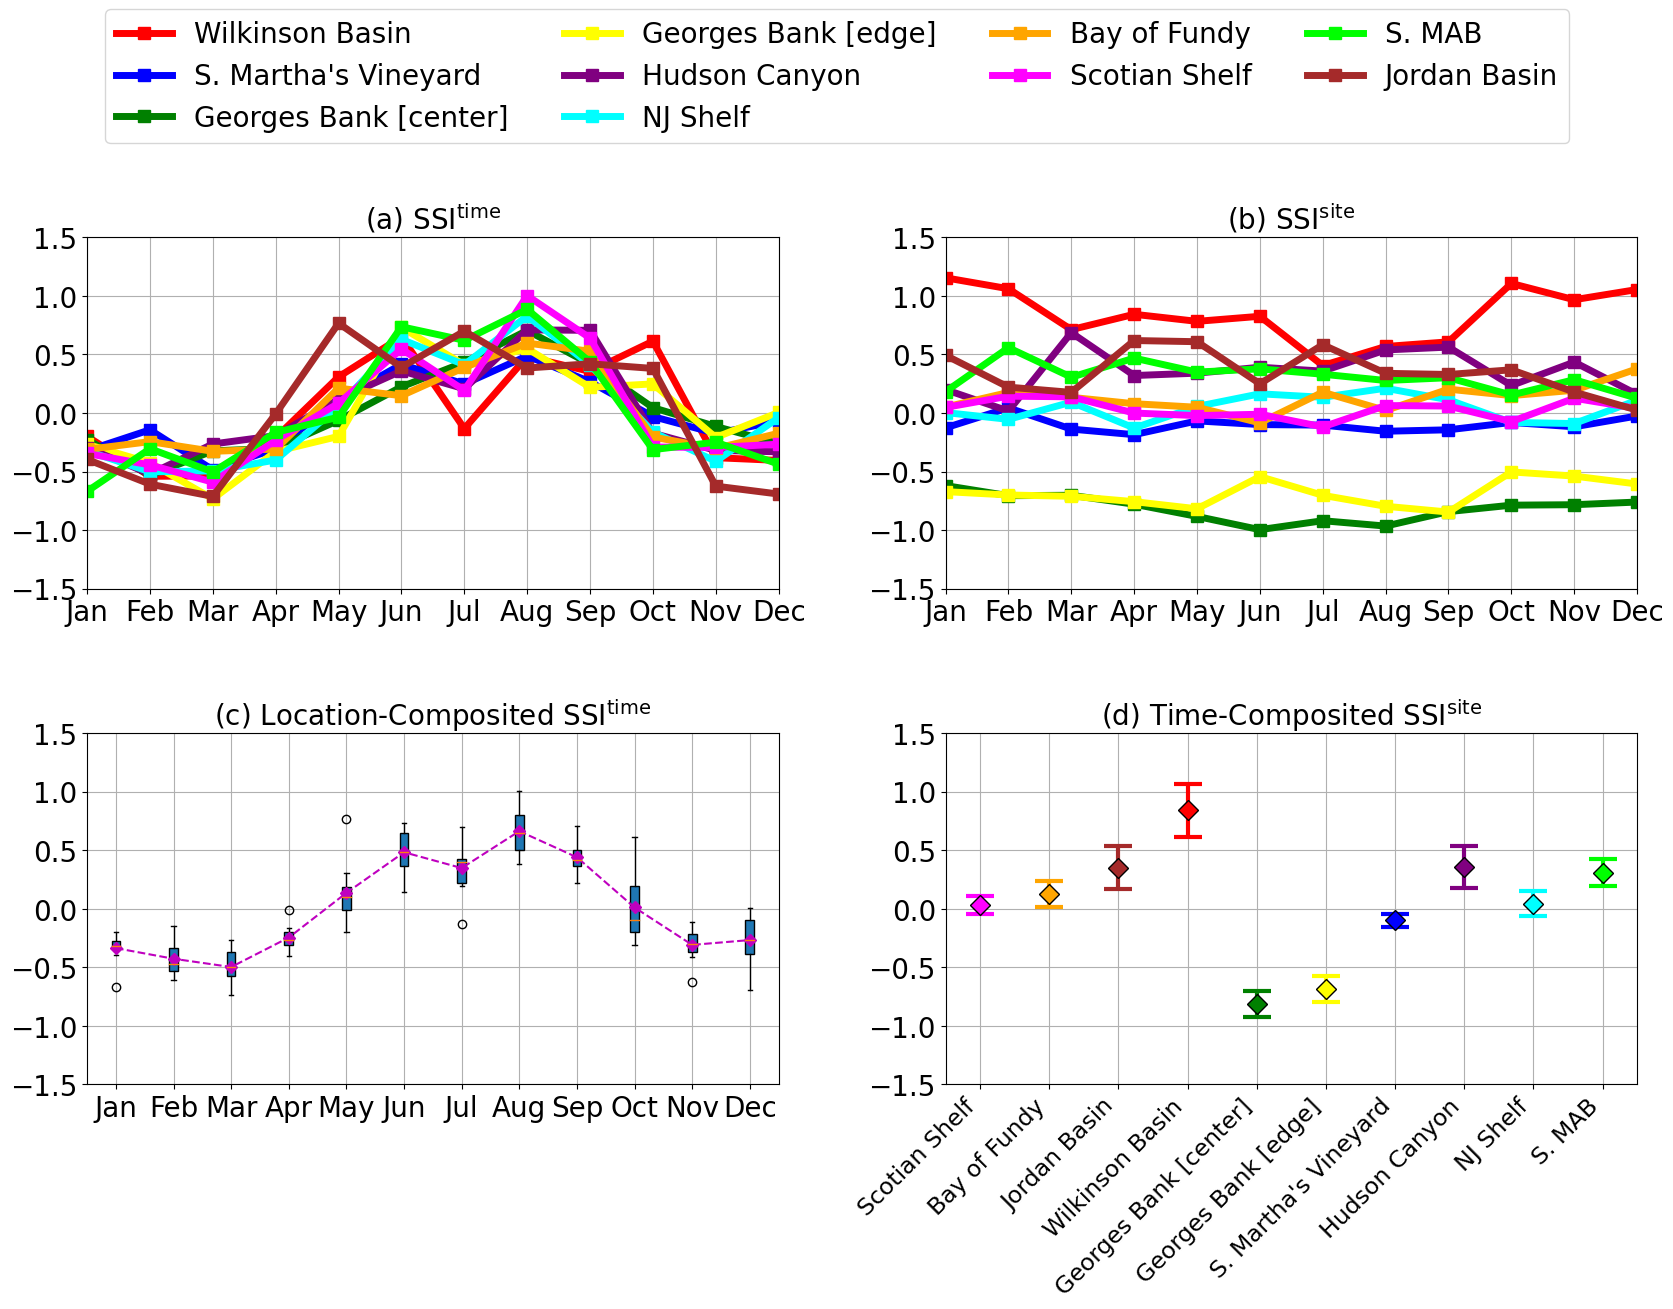

In [5]:
metrics = ['Area','Dist','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']
for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_normalized'] = np.zeros((12,10))
    for i in range(len(locations)):
        series = vars()[metric+'_mean_mean'][:,i];
        series_normal = (series-np.mean(series))/np.std(series)
        if metric in ['Area','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']:
            vars()[metric+'_normalized'][:,i] = series_normal
        elif metric in ['Dist']:
            vars()[metric+'_normalized'][:,i] = -1*series_normal       
SSI_time = np.zeros((12,10));
for m in range(len(metrics)):
    metric = metrics[m];
    for l in range(len(locations)):
        SSI_time[:,l] += vars()[metric+'_normalized'][:,l]*(R2[m,l]/np.sum(R2[:,l]))
#SSI_time = SSI_time/len(metrics);

for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_normalized'] = np.zeros((12,10))
    for i in range(12):
        series = vars()[metric+'_mean_mean'][i,:];
        series_normal = (series-np.mean(series))/np.std(series)
        if metric in ['Area','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']:
            vars()[metric+'_normalized'][i,:] = series_normal
        elif metric in ['Dist']:
            vars()[metric+'_normalized'][i,:] = -1*series_normal 
SSI_site = np.zeros((12,10));
for m in range(len(metrics)):
    metric = metrics[m];
    for l in range(len(locations)):
        SSI_site[:,l] += vars()[metric+'_normalized'][:,l]*(R2[m,l]/np.sum(R2[:,l]))
#SSI_site = SSI_site/len(metrics);

colors = ['Red', 'Blue', 'Green', 'Yellow', 'Purple', 'Cyan', 'Orange', 'Magenta', 'Lime', 'Brown']
xticklabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig = plt.figure(figsize=(20,11)); lw = 5; ms = 8; k=0; fs=20;
gs = fig.add_gridspec(7,11)
subplots = [gs[0:3,0:5],gs[0:3,6:11],gs[4:7,0:5],gs[4:7,6:11]]


fig.add_subplot(subplots[0])
for i in range(len(locations)):
    plt.plot(SSI_time[:,i],'-s',color=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
plt.title(r'(a) SSI$^{\rm time}$',fontsize=fs);
plt.grid();plt.xlim(0,11);plt.ylim(-1.5,1.5);
plt.xticks(np.arange(0,12,1),xticklabels,fontsize=fs);plt.yticks(fontsize=fs);
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=4, fontsize=fs);

fig.add_subplot(subplots[1])
for i in range(len(locations)):
    value = np.mean(SSI_site[:,i])
    plt.plot(SSI_site[:,i],'-s',color=colors[i],ms=ms,linewidth=lw,label=locations_long[i]); 
plt.title(r'(b) SSI$^{\rm site}$',fontsize=fs);
plt.grid();plt.xlim(0,11);plt.ylim(-1.5,1.5);
plt.xticks(np.arange(0,12,1),xticklabels,fontsize=fs);plt.yticks(fontsize=fs);

weights = [1,1,1,1,1,1,1,1]
for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_normalized'] = np.zeros((12,10))
    for i in range(len(locations)):
        series = vars()[metric+'_mean_mean'][:,i];
        series_normal = (series-np.mean(series))/np.std(series)
        if metric in ['Area','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']:
            vars()[metric+'_normalized'][:,i] = series_normal
        elif metric in ['Dist']:
            vars()[metric+'_normalized'][:,i] = -1*series_normal
SSI_time = np.zeros((12,10));
for m in range(len(metrics)):
    metric = metrics[m];
    for l in range(len(locations)):
        SSI_time[:,l] += vars()[metric+'_normalized'][:,l]*(R2[m,l]/np.sum(R2[:,l]))
#SSI_time = SSI_time/len(metrics);
    
for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_normalized'] = np.zeros((12,10))
    for i in range(12):
        series = vars()[metric+'_mean_mean'][i,:];
        series_normal = (series-np.mean(series))/np.std(series)
        if metric in ['Area','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']:
            vars()[metric+'_normalized'][i,:] = series_normal
        elif metric in ['Dist']:
            vars()[metric+'_normalized'][i,:] = -1*series_normal 
SSI_site = np.zeros((12,10));
for m in range(len(metrics)):
    metric = metrics[m];
    for l in range(len(locations)):
        SSI_site[:,l] += vars()[metric+'_normalized'][:,l]*(R2[m,l]/np.sum(R2[:,l]))
#SSI_site = SSI_site/len(metrics);

fig.add_subplot(subplots[2])
for m in range(12):
    plt.boxplot(SSI_time[m,:],positions=[m],patch_artist=True)
for m in range(12):
    mean_value = np.mean(SSI_time[m,:])
    plt.plot(m, mean_value, 'mD')  # 'rD' is a red diamond marker for the mean
plt.plot(np.mean(SSI_time,axis=1),'--m')  # 'rD' is a red diamond marker for the mean
plt.title(r'(c) Location-Composited SSI$^{\rm time}$',fontsize=fs);
plt.grid();plt.xlim(-0.5,11.5);plt.ylim(-1.5,1.5);
plt.xticks(np.arange(0,12,1),xticklabels,fontsize=fs);plt.yticks(fontsize=fs);

locations_new = ['SCS','NGM','JB','Wilkinson','GB','GB2','SMV','HC','NJS','CHE'] 
locations_long_new = ['Scotian Shelf','Bay of Fundy','Jordan Basin','Wilkinson Basin','Georges Bank [center]','Georges Bank [edge]','S. Martha\'s Vineyard','Hudson Canyon','NJ Shelf','S. MAB'] 

fig.add_subplot(subplots[3])
SSI_site_mean = np.zeros((len(locations)));SSI_site_std = np.zeros((len(locations)));
for i in range(len(locations_new)):
    dye_num = locations.index(locations_new[i]);
    SSI_site_mean[i] = np.mean(SSI_site[:,dye_num]);
    SSI_site_std[i] = np.std(SSI_site[:,dye_num]);
    plt.errorbar(i,np.mean(SSI_site[:,dye_num]),yerr=np.std(SSI_site[:,dye_num]),fmt='D',color=colors[dye_num],ecolor=colors[dye_num],capsize=10,markersize=10,elinewidth=3,capthick=3,markeredgecolor='black')
plt.title(r'(d) Time-Composited SSI$^{\rm site}$',fontsize=fs);
plt.grid();plt.xlim(-0.5,9.5);plt.ylim(-1.5,1.5);
plt.xticks(np.arange(0,len(locations_new),1),locations_long_new,rotation=45,fontsize=fs-3,ha='right');plt.yticks(fontsize=fs);

#plt.savefig(outpath+'Fig5_SSI.png',bbox_inches='tight',dpi = 150)


In [6]:
SSI_site_mean

array([ 0.03252229,  0.12727393,  0.34923291,  0.84087672, -0.81240756,
       -0.68315079, -0.09996791,  0.35345352,  0.04413837,  0.30958158])

<font size=5> Figure 6. Seasonality vs Interannual

In [52]:
years = np.arange(2009,2018,1); months = np.arange(1,13,1);
metrics = ['Area','Dist','Direction','Maximum','Concentration_mld','Fraction_mld','Fraction_10','mld','decay_time','transfer_vel']
variables = ['surface_extent_1e_5_1','centroid_dist','centroid_direction','maximum_concentration','mean_concentration_mld_pdens',
             'concentration_mld_pdens','concentration_10m','mld','decay_time_0_1percent_1','gas_transfer_vel']
files = ['Surface_extent.nc','Lateral_dist_direction_surface_centroid.nc','Lateral_dist_direction_surface_centroid.nc','Surface_maximum_decay_time.nc',
        'Dye_patch_concentration.nc','Dye_fraction_Mixed_Layer.nc','Dye_fraction_surface_10m.nc','mld_pdens5m.nc','Surface_maximum_decay_time.nc','Gas_transfer_velocity_CO2.nc']

folder = '/proj/neon/yguo/passive_2009_2017/Experiments_MPDATA_Point1/'

for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_monthly_series'] = np.zeros((12*len(years),len(locations)))
    for yr in years:
        for mon in np.arange(1,13,1):
            dataset = nc.Dataset(folder+'output_'+str(yr)+'/month_'+str(mon).zfill(2)+'/'+files[m],'r')
            if metric in ['Fraction_10']:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_monthly_series'][(yr-years[0])*12+mon-1,:] = np.mean(dataset.variables['concentration_10m'][:,0:days]/dataset.variables['concentration_total'][:,0:days],axis=1)
            elif metric in ['Fraction_mld']:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_monthly_series'][(yr-years[0])*12+mon-1,:] = np.mean(dataset.variables['concentration_mld_pdens'][:,0:days]/dataset.variables['concentration_total'][:,0:days],axis=1)
            elif metric in ['mld']:
                narea = 200; days = dataset.variables[variables[m]][:].shape[0]
                for i in range(len(locations)):
                    dist = (lat_rho-vars()[locations[i]+'_lat_center'])**2+(lon_rho-vars()[locations[i]+'_lon_center'])**2
                    ilat = np.where(dist==np.min(dist))[0][0];ilon = np.where(dist==np.min(dist))[1][0];
                    data = np.nanmean(np.nanmean(dataset.variables['mld'][:,ilat-narea:ilat+narea,ilon-narea:ilon+narea],axis=2),axis=1)
                    vars()[metric+'_monthly_series'][(yr-years[0])*12+mon-1,:] = np.nanmean(data)
            elif metric in ['decay_time']:
                vars()[metric+'_monthly_series'][(yr-years[0])*12+mon-1,:] = dataset.variables['decay_time_0_1percent_1'][:]

            else:
                days = dataset.variables[variables[m]][:].shape[1]
                vars()[metric+'_monthly_series'][(yr-years[0])*12+mon-1,:] = np.mean(dataset.variables[variables[m]][:,0:days],axis=1)
            dataset.close();
            
for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_seasonal_variance'] = np.zeros((len(locations)))
    vars()[metric+'_interannual_variance'] = np.zeros((len(locations)))
    for i in range(len(locations)):
        series = vars()[metric+'_monthly_series'][:,i]
        stl = STL(series, period=12)
        result = stl.fit()
        vars()[metric+'_seasonal_variance'][i] = np.var(result.seasonal)
        vars()[metric+'_interannual_variance'][i] = np.var(result.trend)+np.var(result.resid)
        

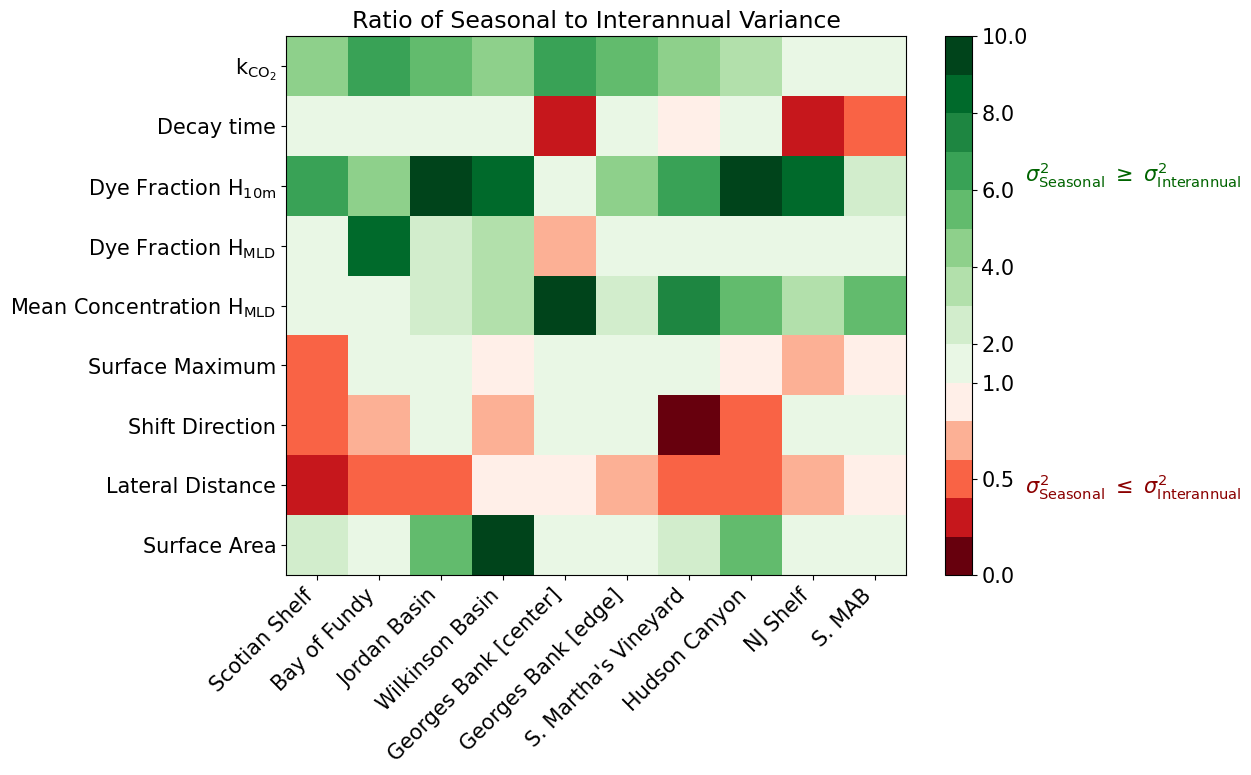

In [53]:
metrics = ['Area','Dist','Direction','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']
metrics_long = ['Surface Area','Lateral Distance','Shift Direction','Surface Maximum',r'Mean Concentration H$_{\rm MLD}$',r'Dye Fraction H$_{\rm MLD}$',r'Dye Fraction H$_{\rm 10m}$','Decay time',r'k$_{\rm CO_{2}}$']

cmap_dense = plt.cm.Greens#cm.dens
n_dense_colors = 256
dense_colors = [cmap_dense(i / (n_dense_colors - 1)) for i in range(n_dense_colors)]
cmap_reds = plt.cm.Reds_r
n_reds_colors = 120
reds_colors = [cmap_reds(i / (n_reds_colors - 1)) for i in range(n_reds_colors)]
combined_colors = reds_colors+dense_colors
cmap_color = mcolors.LinearSegmentedColormap.from_list('my_list', combined_colors)
boundaries = [0,0.2,0.4,0.6,0.8,1,2,3,4,5,6,7,8,9,10]
norm = mcolors.BoundaryNorm(boundaries, ncolors=cmap_color.N)

locations_new = ['SCS','NGM','JB','Wilkinson','GB','GB2','SMV','HC','NJS','CHE'] 
locations_long_new = ['Scotian Shelf','Bay of Fundy','Jordan Basin','Wilkinson Basin','Georges Bank [center]','Georges Bank [edge]','S. Martha\'s Vineyard','Hudson Canyon','NJ Shelf','S. MAB']     

ratio = np.zeros((len(metrics),len(locations)));
for m in range(len(metrics)):
    metric = metrics[m];
    for i in range(len(locations_new)):
        dye_num = locations.index(locations_new[i]);
        ratio[m,i] = vars()[metric+'_seasonal_variance'][dye_num]/vars()[metric+'_interannual_variance'][dye_num]
    
plt.figure(figsize=(10,7));fs = 15;
plt.pcolormesh(ratio,cmap=cmap_color,norm=norm);cbar=plt.colorbar(); cbar.set_ticks([0,0.5,1,2,4,6,8,10]);
cbar.ax.tick_params(labelsize=fs);
plt.title('Ratio of Seasonal to Interannual Variance',fontsize=fs+2);
# cbar.ax.text(4, 0.53, r'$\sigma^{2}_{\rm Seasonal}$ $\geq$ $\sigma^{2}_{\rm Interannual}$', color='darkgreen',rotation=90,transform=cbar.ax.transAxes, ha='center');
# cbar.ax.text(4, 0, r'$\sigma^{2}_{\rm Seasonal}$ $\leq$ $\sigma^{2}_{\rm Interannual}$',color='darkred',rotation=90,transform=cbar.ax.transAxes, ha='center');
cbar.ax.text(7, 0.73, r'$\sigma^{2}_{\rm Seasonal}$ $\geq$ $\sigma^{2}_{\rm Interannual}$', color='darkgreen',rotation=0,transform=cbar.ax.transAxes, ha='center',fontsize=fs);
cbar.ax.text(7, 0.15, r'$\sigma^{2}_{\rm Seasonal}$ $\leq$ $\sigma^{2}_{\rm Interannual}$',color='darkred',rotation=0,transform=cbar.ax.transAxes, ha='center',fontsize=fs);
plt.xticks(np.arange(0.5,len(locations_new),1),locations_long_new,rotation=45,ha='right',fontsize=fs);
plt.yticks(np.arange(0.5,len(metrics),1),metrics_long,rotation=0,ha='right',fontsize=fs);

#plt.savefig(outpath+'Fig6_Interannual.png',bbox_inches='tight',dpi = 150)


<font size=5> Figure 7. Sensitivity

In [54]:
metrics = ['Area','Dist','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']
for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_normalized'] = np.zeros((12,10))
    for i in range(len(locations)):
        series = vars()[metric+'_mean_mean'][:,i];
        series_normal = (series-np.mean(series))/np.std(series)
        if metric in ['Area','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']:
            vars()[metric+'_normalized'][:,i] = series_normal
        elif metric in ['Dist']:
            vars()[metric+'_normalized'][:,i] = -1*series_normal

sens = np.arange(1/10,20,0.1);
sens = np.arange(0,5,0.5);

for m in range(len(metrics)):
    metric = metrics[m]
    vars()['index_time_'+metric] = np.zeros((len(sens),12,10));

for m in range(len(metrics)):
    metric = metrics[m];
    for s in range(len(sens)):
        weights = np.ones(len(metrics));
        weights[m] = sens[s];
        for m1 in range(len(metrics)):
            metric1 = metrics[m1];
            vars()['index_time_'+metric][s,:,:] += vars()[metric1+'_normalized']*weights[m1]/np.sum(weights)
 
e_index_time = np.zeros((len(metrics),12)); degree = 1;
for m in range(len(metrics)):
    metric = metrics[m];
    for mon in range(12):
        ee = np.zeros(len(locations))
        for i in range(len(locations)):
            x_data,y_data = sens,vars()['index_time_'+metric][:,mon,i]
            coefficients = np.polyfit(x_data, y_data, degree)
            a_fit, b_fit = coefficients
            ee[i] = a_fit 
        e_index_time[m,mon] = np.mean(ee)


In [55]:
metrics = ['Area','Dist','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']
for m in range(len(metrics)):
    metric = metrics[m];
    vars()[metric+'_normalized'] = np.zeros((12,10))
    for mon in range(12):
        series = vars()[metric+'_mean_mean'][mon,:];
        series_normal = (series-np.mean(series))/np.std(series)
        if metric in ['Area','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']:
            vars()[metric+'_normalized'][mon,:] = series_normal
        elif metric in ['Dist']:
            vars()[metric+'_normalized'][mon,:] = -1*series_normal 

sens = np.arange(1/10,20,0.1);
sens = np.arange(0,5,0.5);

for m in range(len(metrics)):
    metric = metrics[m]
    vars()['index_site_'+metric] = np.zeros((len(sens),12,10));

for m in range(len(metrics)):
    metric = metrics[m];
    for s in range(len(sens)):
        weights = np.ones(len(metrics));
        weights[m] = sens[s];
        for m1 in range(len(metrics)):
            metric1 = metrics[m1];
            vars()['index_site_'+metric][s,:,:] += vars()[metric1+'_normalized']*weights[m1]/np.sum(weights)
 
e_index_site = np.zeros((len(metrics),len(locations))); degree = 1;
for m in range(len(metrics)):
    metric = metrics[m];
    for i in range(len(locations)):
        ee = np.zeros(12)
        for mon in range(12):
            x_data,y_data = sens,vars()['index_site_'+metric][:,mon,i]
            coefficients = np.polyfit(x_data, y_data, degree)
            a_fit, b_fit = coefficients
            ee[i] = a_fit 
        e_index_site[m,i] = np.mean(ee)


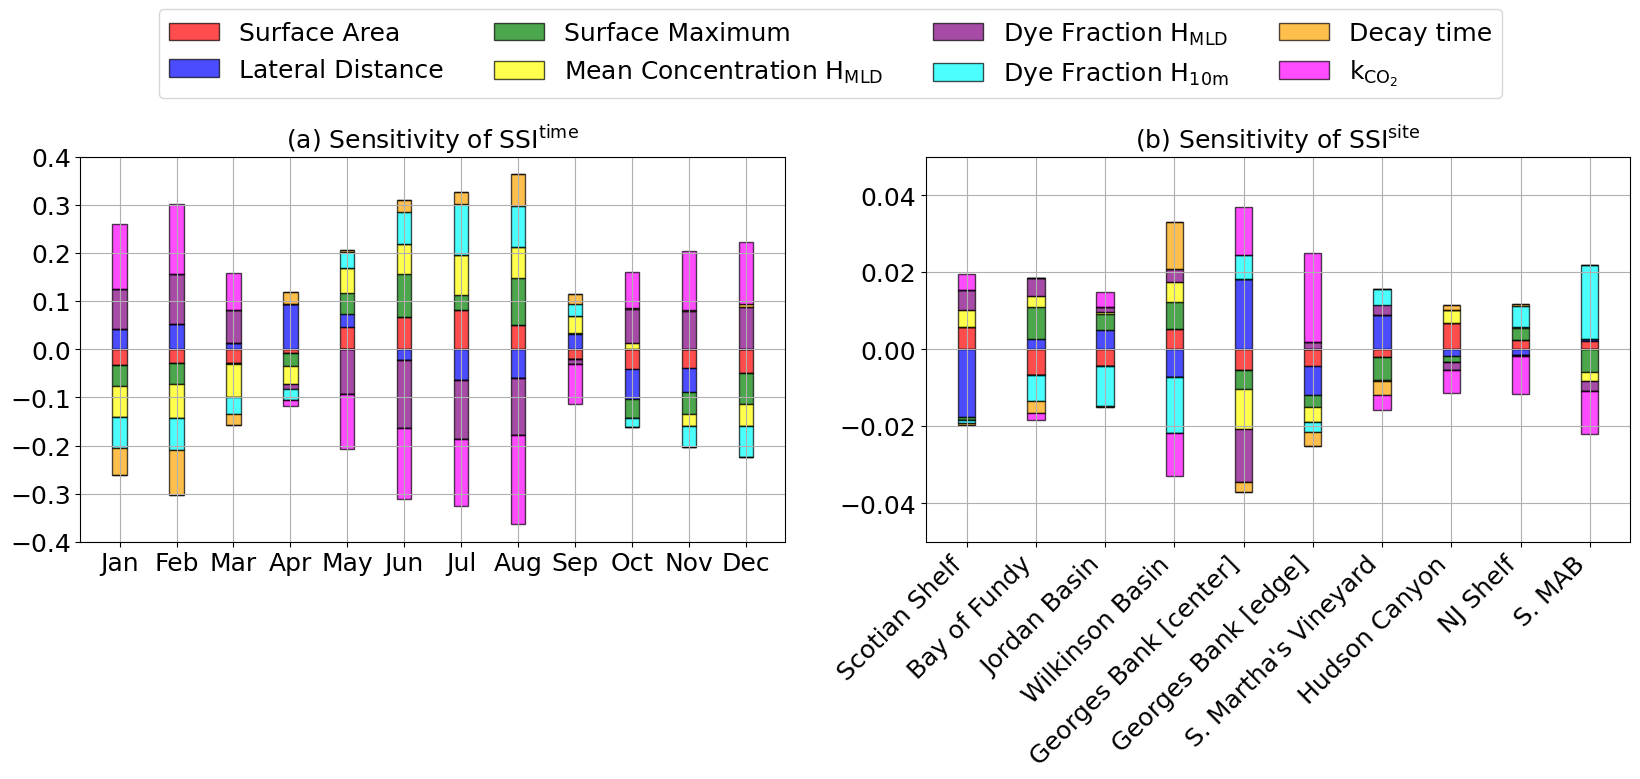

In [56]:
metrics = ['Area','Dist','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']
titles = ['Surface Area','Lateral Distance','Surface Maximum',r'Mean Concentration H$_{\rm MLD}$',r'Dye Fraction H$_{\rm MLD}$',r'Dye Fraction H$_{\rm 10m}$','Decay time',r'k$_{\rm CO_{2}}$']

variables = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'];
# set height of bar 
for m in range(len(metrics)):
    vars()['group_'+metrics[m]] = list(range(len(variables)))
    for v in range(len(variables)):
        vars()['group_'+metrics[m]][v] = 1*(e_index_time[m,v])

fig = plt.figure(figsize =(20,5)); fs = 18; alpha=0.7;
ax = fig.add_subplot(1,2,1)
colors = ['Red', 'Blue', 'Green', 'Yellow', 'Purple', 'Cyan', 'Orange', 'Magenta', 'Lime', 'Brown']
# set width of bar 
barWidth = 0.25
br1 = np.arange(len(variables)) 
bottom_pos = np.zeros(len(variables));bottom_neg = np.zeros(len(variables));
for m, metric in enumerate(metrics):
    current_values = vars()['group_'+metric]
    
    positive_values = np.maximum(current_values, 0)
    negative_values = np.minimum(current_values, 0)
    
    # Plot bars for positive values
    plt.bar(br1, positive_values, bottom=bottom_pos,width = barWidth,color=colors[m],edgecolor ='k',alpha=alpha,label=titles[m]) 
    bottom_pos += positive_values
    
    # Plot bars for negative values
    plt.bar(br1, negative_values, bottom=bottom_neg,width = barWidth,color=colors[m],edgecolor ='k',alpha=alpha) 
    bottom_neg += negative_values

plt.xticks([r for r in range(len(variables))],variables,fontsize=fs);plt.yticks(fontsize=fs);
plt.ylim(-0.4,0.4); plt.grid(); plt.title(r'(a) Sensitivity of SSI$^{\rm time}$',fontsize=fs);
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),ncol=4, fontsize=fs);


metrics = ['Area','Dist','Maximum','Concentration_mld','Fraction_mld','Fraction_10','decay_time','transfer_vel']
titles = ['Surface Area','Lateral Distance','Surface Maximum',r'Mean Concentration H$_{\rm MLD}$',r'Dye Fraction H$_{\rm MLD}$',r'Dye Fraction H$_{\rm 10m}$','Decay time',r'k$_{\rm CO_{2}}$']
locations_new = ['SCS','NGM','JB','Wilkinson','GB','GB2','SMV','HC','NJS','CHE'] 
locations_long_new = ['Scotian Shelf','Bay of Fundy','Jordan Basin','Wilkinson Basin','Georges Bank [center]','Georges Bank [edge]','S. Martha\'s Vineyard','Hudson Canyon','NJ Shelf','S. MAB']     

# set height of bar 
for m in range(len(metrics)):
    vars()['group_'+metrics[m]] = list(range(len(locations_new)))
    for i in range(len(locations_new)):
        dye_num = locations.index(locations_new[i]);
        vars()['group_'+metrics[m]][i] = 1*(e_index_site[m,dye_num])
        
fig.add_subplot(1,2,2)
# set width of bar 
barWidth = 0.25
br1 = np.arange(len(locations_new)) 
bottom_pos = np.zeros(len(locations_new));bottom_neg = np.zeros(len(locations_new));
for m, metric in enumerate(metrics):
    current_values = vars()['group_'+metric]
    
    positive_values = np.maximum(current_values, 0)
    negative_values = np.minimum(current_values, 0)
    
    # Plot bars for positive values
    plt.bar(br1, positive_values, bottom=bottom_pos,width = barWidth,color=colors[m],edgecolor ='k',alpha=alpha,label=titles[m]) 
    bottom_pos += positive_values
    
    # Plot bars for negative values
    plt.bar(br1, negative_values, bottom=bottom_neg,width = barWidth,color=colors[m],edgecolor ='k',alpha=alpha) 
    bottom_neg += negative_values

plt.xticks([r for r in range(len(locations_new))],locations_long_new,fontsize=fs,rotation=45,ha='right');plt.yticks(fontsize=fs);
#plt.legend(fontsize=fs,bbox_to_anchor=(1,0.85)); 
plt.grid(); plt.ylim(-0.05,0.05); plt.title(r'(b) Sensitivity of SSI$^{\rm site}$',fontsize=fs);

#plt.savefig(outpath+'Fig7_Sensitivity.png',bbox_inches='tight',dpi = 150)
